In [1]:
import pandas as pd
import numpy as np
import os
import gc
from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold
from scipy.stats import ttest_ind, ks_2samp
import pickle
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns 

from utilities import (
    RANDOM_STATE, TARGET_COL, CAT_TRESHOLD, N_FOLD, FOLD_STRAT_NAME,
    reduce_mem_usage_sd
)
    

INPUT_PATH = '../input/tabular-playground-series-oct-2021'

In [2]:
train = pd.read_csv(
    os.path.join(INPUT_PATH, 'train.csv')
).drop(['id', TARGET_COL], axis = 1)

train['adversarial_target'] = 0

train = reduce_mem_usage_sd(train)
gc.collect()

  0%|          | 0/286 [00:00<?, ?it/s]

Mem. usage decreased from 2182.01 Mb to 959.40 Mb (56.0% reduction)


0

In [3]:
test = pd.read_csv(
    os.path.join(INPUT_PATH, 'test.csv')
).drop('id', axis = 1)

test['adversarial_target'] = 1

test = reduce_mem_usage_sd(test)
gc.collect()

  0%|          | 0/286 [00:00<?, ?it/s]

Mem. usage decreased from 1091.00 Mb to 479.70 Mb (56.0% reduction)


0

In [4]:
TARGET_COL = 'adversarial_target'
FEATURE = [x for x in train.columns if x != TARGET_COL]

In [5]:
concat_data = train.append(test)

del train, test
gc.collect()

concat_data = reduce_mem_usage_sd(concat_data)

concat_data = concat_data.reset_index(drop = True)

  0%|          | 0/286 [00:00<?, ?it/s]

Mem. usage decreased from 1450.54 Mb to 1450.54 Mb (0.0% reduction)


In [6]:
CAT_COL = [x for x in FEATURE if concat_data[x].nunique()<= CAT_TRESHOLD]

NUMERIC_COL = [x for x in FEATURE if x not in CAT_COL]

In [7]:
params_lgb = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'metric': 'auc',
        'learning_rate': 0.3,
        'max_depth': -1,
        'num_leaves': 2**10,
        'n_jobs':1,
        'verbose': -1,
        'feature_fraction': 0.75,
        'bagging_fraction': 0.75,
        'bagging_freq': 1,
        'tree_learner': 'voting'

}
gc.collect()

21

In [8]:
strat_fold = StratifiedKFold(n_splits = N_FOLD, random_state = RANDOM_STATE, shuffle = True)

for i, (train_index, test_index) in enumerate(strat_fold.split(concat_data[FEATURE], concat_data[TARGET_COL])):
    
    if i == 0:
        train_x, train_y = concat_data.loc[train_index, FEATURE], concat_data.loc[train_index, TARGET_COL]
        test_x, test_y = concat_data.loc[test_index, FEATURE], concat_data.loc[test_index, TARGET_COL]

        model = lgb.train(
            params_lgb,
            lgb.Dataset(train_x, label=train_y,categorical_feature=CAT_COL), 60,
            valid_sets = lgb.Dataset(test_x, label=test_y,categorical_feature=CAT_COL),
            valid_names ='validation', verbose_eval=5, early_stopping_rounds = 5,
        )

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 5 rounds
[5]	validation's auc: 0.886744
[10]	validation's auc: 0.924338
[15]	validation's auc: 0.942688
[20]	validation's auc: 0.953443
[25]	validation's auc: 0.960035
[30]	validation's auc: 0.965015
[35]	validation's auc: 0.96855
[40]	validation's auc: 0.97143
[45]	validation's auc: 0.973474
[50]	validation's auc: 0.975404
[55]	validation's auc: 0.976868
[60]	validation's auc: 0.977879
Did not meet early stopping. Best iteration is:
[60]	validation's auc: 0.977879


In [9]:
feature_importances = pd.DataFrame(
    {
        'feature': FEATURE,
        'importance': model.feature_importance(importance_type='gain')
    }
).sort_values(by='importance', ascending=False)


feature_importances.to_csv('feature_del_adversarial.csv', index = False)

Text(0.5, 1.0, '50 TOP feature importance')

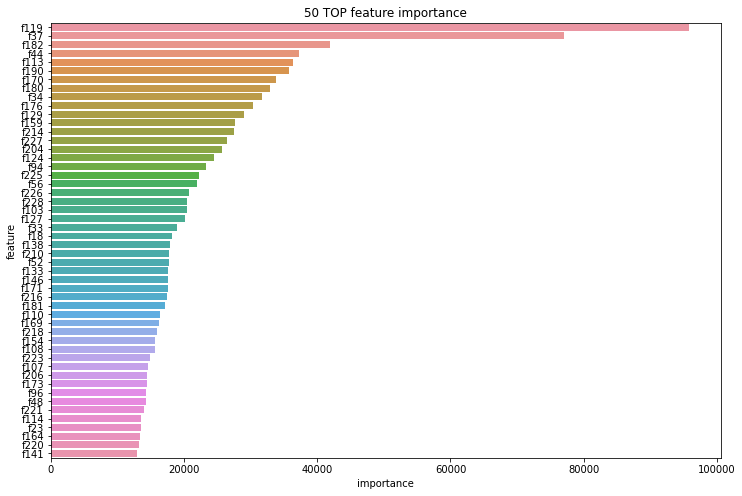

In [10]:
fig = plt.figure(figsize=(12,8))
sns.barplot(data=feature_importances.head(50), x='importance', y='feature');
plt.title('50 TOP feature importance')
